# Regression Used Cars Dataset

https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data 


## **Dependency**

In [2]:
#! pip install lightgbm

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from itertools import combinations  # For creating combinations of elements
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
import lightgbm as lgb 
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn import preprocessing
import re
from sklearn.preprocessing import StandardScaler
import random

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


#### **Utility Function**

In [3]:
def reduce_mem_usage(df, verbose=0):
    """
    Iterate through all numeric columns of a dataframe and modify the data type
    to reduce memory usage.
    """
    # Calculate the initial memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2

    # 🔄 Iterate through each column in the DataFrame
    for col in df.columns:
        col_type = df[col].dtype
        # Check if the column's data type is not 'object' (i.e., numeric)
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            # Check if the column's data type is an integer
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            elif str(col_type)[:5] == "float":
                # Check if the column's data type is a float
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float32)
    # ℹ️ Provide memory optimization information if 'verbose' is True
    if verbose:
        print(f"Memory usage of dataframe is {start_mem:.2f} MB")
        end_mem = df.memory_usage().sum() / 1024**2
        print(f"Memory usage after optimization is: {end_mem:.2f} MB")
        decrease = 100 * (start_mem - end_mem) / start_mem
        print(f"Decreased by {decrease:.2f}%")

    # Return the DataFrame with optimized memory usage
    return df

## **Load Data**

load csv inside data folder

In [4]:
#kaggle path
df = pd.read_csv('/kaggle/input/craigslist-carstrucks-data/vehicles.csv')
#local path
#df = pd.read_csv("/kaggle/input/vehicles/vehicles.csv")

df=df.convert_dtypes()
df=reduce_mem_usage(df,verbose=True)
#Remove meaningless columns
df.drop(['id','url','region','region_url','title_status',
         'image_url','VIN','size','county','description',
         'state','lat','long'], 
        axis=1, inplace=True)
df.shape
df[0:4]

Memory usage of dataframe is 87.53 MB
Memory usage after optimization is: 87.53 MB
Decreased by 0.00%


,price,year,manufacturer,model,condition,cylinders,fuel,odometer,transmission,drive,type,paint_color,posting_date
0,6000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
1,11900,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
2,21000,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
3,1500,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [5]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         426880 non-null  Int64 
 1   year          425675 non-null  Int64 
 2   manufacturer  409234 non-null  string
 3   model         421603 non-null  string
 4   condition     252776 non-null  string
 5   cylinders     249202 non-null  string
 6   fuel          423867 non-null  string
 7   odometer      422480 non-null  Int64 
 8   transmission  424324 non-null  string
 9   drive         296313 non-null  string
 10  type          334022 non-null  string
 11  paint_color   296677 non-null  string
 12  posting_date  426812 non-null  string
dtypes: Int64(3), string(10)
memory usage: 43.6 MB


In [6]:
df[(df['manufacturer']=="ford")]['model'].unique()

<StringArray>
[                  'f-150 xlt',  'ranger supercrew xl pickup',
 'f150 super cab xl pickup 4d',      'f150 supercrew cab xlt',
   'ranger supercab xl pickup',             'f250 super duty',
  'f150 regular cab xl pickup',          'mustang gt premium',
                        'f450',        'expedition xlt sport',
 ...
     'e450 super duty cutaway',   'e-series chassis e-350 sd',
              'f15o fx4 sport',              'f-150 heritage',
         'ranger pickup truck',                  'ranger rmt',
        'f250 crew cab diesel',             'taurus wagon lx',
                   'f150, xlt',              'f150, platinum']
Length: 3875, dtype: string

In [7]:
df.loc[(df['manufacturer']=="audi") & (df['model']=="a6"), "cylinders"].isna().sum()

116

## **Data Visualisation**

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

Let us proceed to check for possible correlations between variables. What we are most interested in are those variables that are related to the price of the vehicle:

<Axes: >

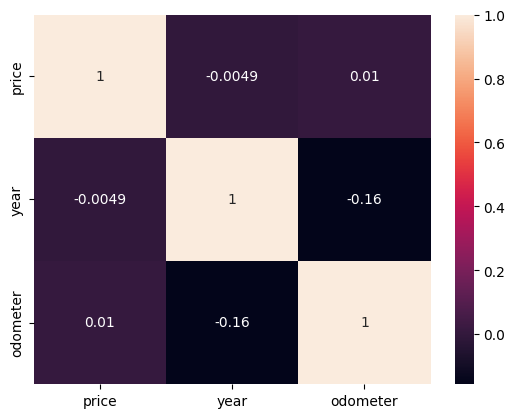

In [9]:
sns.heatmap(df.corr(numeric_only=True), annot=True)

As we can see, the most important numeric variables with respect to price is the year of manufacture. There is a positive correlation that indicates that the higher the year of manufacture (and therefore, the fewer years the vehicle has been manufactured), the higher its value.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


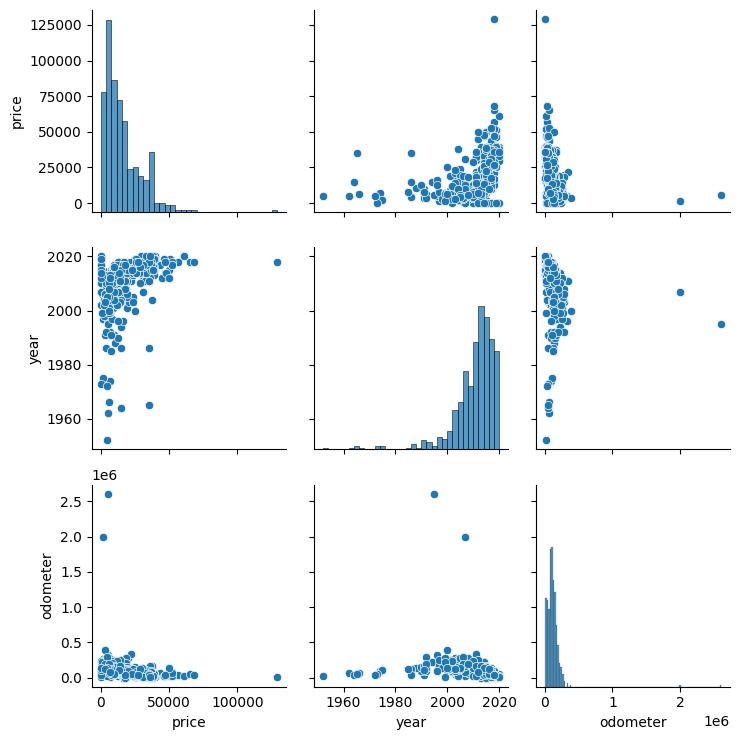

In [11]:
# Pairplot
sns.pairplot(df.dropna().sample(500))
plt.tight_layout()
plt.savefig('Insight-Pair-Plot',dpi=None)
plt.show()

- Diagonal plots are histograms showing the distribution of a single variable. For instance, the distribution of the `price` variable is right-skewed, indicating that most of the cars are priced on the lower end, with few expensive outliers.
- Off-diagonal plots are scatter plots showing the relationship between two variables. For example, there's a scatter plot comparing price and year, which indicates a trend that newer cars tend to be more expensive.
- Similarly, we can observe some expected trends, such as higher odometer readings for older cars.

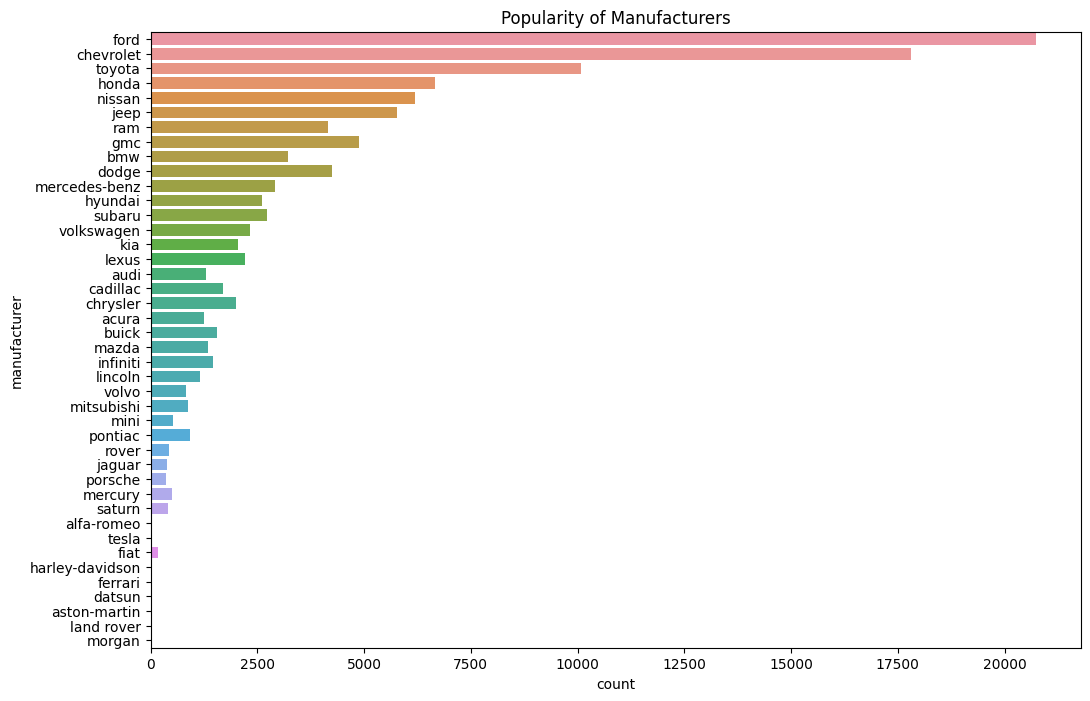

In [12]:
# Manufacturer Popularity
plt.figure(figsize=(12, 8))
sns.countplot(y='manufacturer', data=df.dropna(), order = df['manufacturer'].value_counts().index)
plt.title('Popularity of Manufacturers')
plt.show()

The chart above indicates the popularity of automakers, with Ford, Chevrolet, and Toyota being the top three most listed.

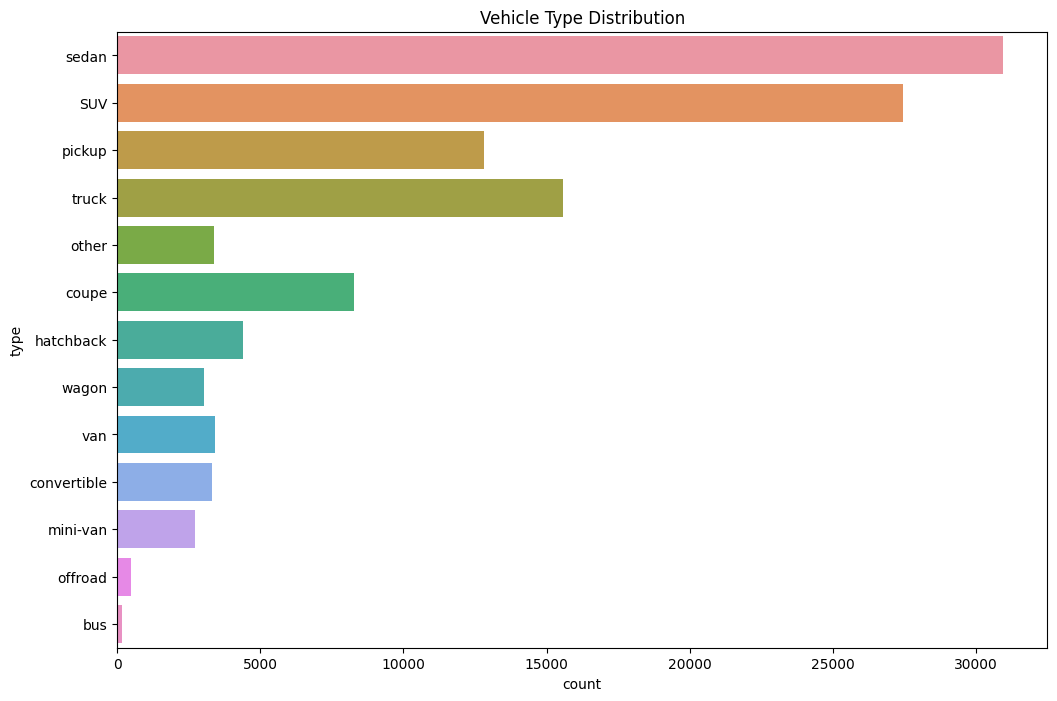

In [13]:
# Vehicle Type Distribution
plt.figure(figsize=(12, 8))
sns.countplot(y='type', data=df.dropna(), order=df['type'].value_counts().index)
plt.title('Vehicle Type Distribution')
plt.show()

The bar chart shows the distribution of the different vehicle types in the dataset. Cars and SUVs are the most common vehicle types, while buses and buggies are the least on the list. This distribution reflects consumer purchasing preferences and the intended use of the vehicles, with cars and buggies likely to be the primary vehicles used for various purposes.

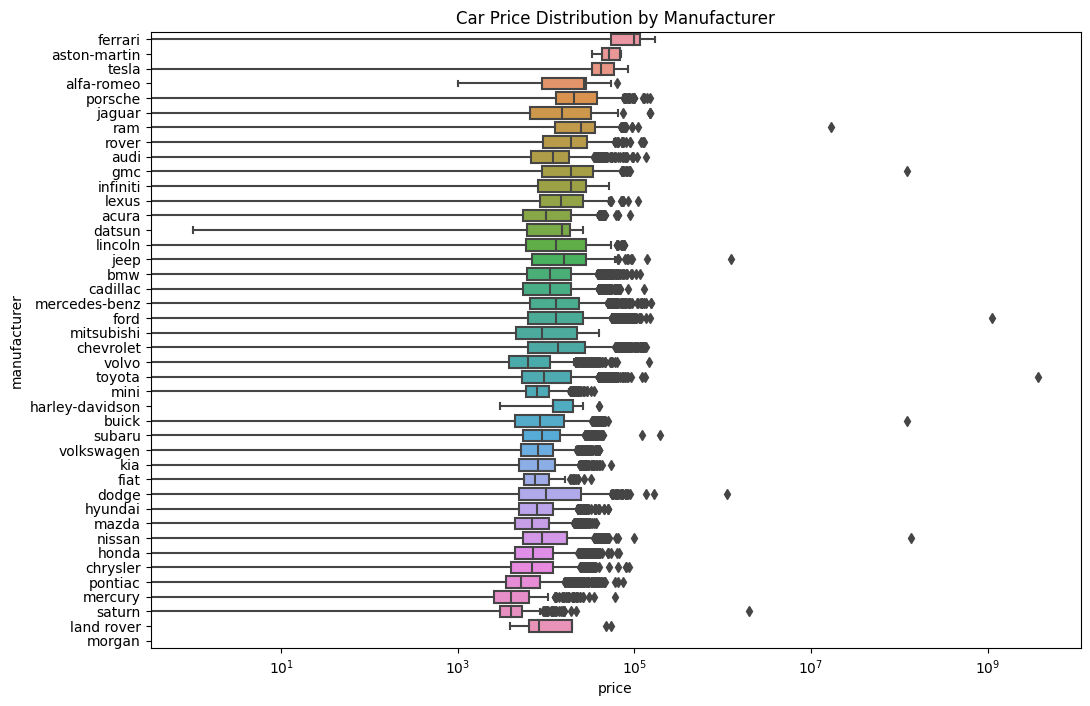

In [14]:
# Car Price Distribution by Manufacturer
plt.figure(figsize=(12, 8))
sns.boxplot(x='price', y='manufacturer', data=df.dropna(), order=df.groupby('manufacturer')['price'].median().sort_values(ascending=False).index)
plt.xscale('log')  # Using logarithmic scale due to wide range of 'price'
plt.title('Car Price Distribution by Manufacturer')
plt.show()

The boxplot indicates that the median prices of vehicles vary significantly across different manufacturers. High-end brands like Ferrari and Aston Martin have higher median prices and also exhibit a wider range of prices, as shown by the length of their boxes and extended whiskers. On the other hand, mainstream manufacturers such as Honda, Ford, and Toyota have more compact interquartile ranges, suggesting a smaller variance in vehicle prices.

## **Split dataset** 

In [15]:
df_train, df_test = train_test_split(df, test_size=0.2,random_state=4487)
print(df_train.shape, df_test.shape)

(341504, 13) (85376, 13)


## **Data Function**

data preperation

feature engineering

In [16]:
def data_preparation(df:pd.DataFrame)->pd.DataFrame:
    """"
    make data valid
    """
    def keep_first_word(s):
        if pd.notnull(s):  # Use pd.notnull instead of not pd.isnull
            s = str(s).lower()
            s=s.split()[0]
            s = re.sub('[^a-zA-Z0-9]', '', s)
            if(len(s)<3):
                return np.nan
            else:
                return s
        else:
            return np.nan  # Return np.nan for null values

    # filter weird string
    df['model'] = df['model'].apply(keep_first_word)
    md = df['model'].value_counts()
    df = df.dropna(subset=['year','manufacturer', 'model'])



    # remove oultier
    df = df[(df['price']<df['price'].quantile(0.99)) & (df['price']>df['price'].quantile(0.01))]
    # clean the odometer data by computing averge between 0.05 and 0.95

    o1 = df['odometer'].quantile(0.95)
    o2 = df['odometer'].quantile(0.05)
    odometer_avg= df[(df['odometer']<o1) & (df['odometer']>o2)]['odometer'].mean()
    df['odometer'] = df['odometer'].fillna(int(odometer_avg))


    # Take the popular models
    df['model'] = df['model'].apply(lambda s: str(s) if str(s) in md[:50] else "unknown")

    # Take the popular manufacturer
    mf = df['manufacturer'].value_counts()
    df['manufacturer'] = df['manufacturer'].apply(lambda s: str(s) if str(s) in mf[:20] else "unknown")

    # fill data from real world !!!!!!
    temp = df.loc[(df['manufacturer']=="ford") & (df['model']=="f150")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="ford") & (df['model']=="f150"), "cylinders"].fillna("6 cylinders")
    temp = df.loc[(df['manufacturer']=="ford") & (df['model']=="ranger")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="ford") & (df['model']=="ranger"), "cylinders"].fillna(random.choice(["4 cylinders","6 cylinders"]))
    temp = df.loc[(df['manufacturer']=="jeep") & (df['model']=="compass")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="jeep") & (df['model']=="compass"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="jeep") & (df['model']=="wrangler")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="jeep") & (df['model']=="wrangler"), "cylinders"].fillna(random.choice(["4 cylinders","6 cylinders"]))
    temp = df.loc[(df['manufacturer']=="toyota") & (df['model']=="tacoma")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="toyota") & (df['model']=="tacoma"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="cadillac") & (df['model']=="xt4")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="cadillac") & (df['model']=="xt4"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="honda") & (df['model']=="civic")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="honda") & (df['model']=="civic"), "cylinders"].fillna("4 cylinders")
    temp = df.loc[(df['manufacturer']=="volvo") & (df['model']=="s60")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="volvo") & (df['model']=="s60"), "cylinders"].fillna(random.choice(["4 cylinders","5 cylinders","6 cylinders"]))
    temp = df.loc[(df['manufacturer']=="audi") & (df['model']=="a6")]
    df.loc[temp.index, "cylinders"]=df.loc[(df['manufacturer']=="audi") & (df['model']=="a6"), "cylinders"].fillna("4 cylinders")
    df['cylinders'] = df['cylinders'].fillna("unknown")



    
    df = df.fillna('unknown')
    df = df.drop_duplicates()

    # turn nominal data into number
    y = df['price']
    x =df.drop(columns=['price'])
    x=x.convert_dtypes()

    return x,y

def feature_engineering(df:pd.DataFrame)->pd.DataFrame:
    """"
    select useful feature
    """
    #vehicle_age=posting_year - year, get the usage time of this vehicle
    df["posting_date"] = pd.to_datetime(df["posting_date"], utc=True)
    df["posting_year"] = df["posting_date"].dt.year
    df["vehicle_age"] = df["posting_year"] - df["year"]
    
    df.drop(['posting_date','posting_year'], 
        axis=1, inplace=True)
    
    return df


def data_preprocessing(df:pd.DataFrame)->pd.DataFrame:
    x , y =data_preparation(df)
    x=feature_engineering(x)
    return x,y



In [17]:
df_train_x,df_train_y = data_preprocessing(df_train)
df_test_x, df_test_y = data_preprocessing(df_test)

print(df_train_x.isna().sum())
print(df['type'].unique())
print(df_train_x.shape, df_train_y.shape)

year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
vehicle_age     0
dtype: int64
<StringArray>
[         <NA>,      'pickup',       'truck',       'other',       'coupe',
         'SUV',   'hatchback',    'mini-van',       'sedan',     'offroad',
         'bus',         'van', 'convertible',       'wagon']
Length: 14, dtype: string
(271244, 12) (271244,)


In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 341504 entries, 55098 to 348812
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   price         341504 non-null  Int64 
 1   year          340545 non-null  Int64 
 2   manufacturer  327517 non-null  string
 3   model         311270 non-null  object
 4   condition     202216 non-null  string
 5   cylinders     199312 non-null  string
 6   fuel          339058 non-null  string
 7   odometer      337948 non-null  Int64 
 8   transmission  339455 non-null  string
 9   drive         236940 non-null  string
 10  type          267417 non-null  string
 11  paint_color   237399 non-null  string
 12  posting_date  341454 non-null  string
dtypes: Int64(3), object(1), string(9)
memory usage: 37.5+ MB


In [19]:
#construct label encoder

def encode(categorical_cols,learn_df,df1,df2):
    for col in categorical_cols:
        le = preprocessing.LabelEncoder()
        print(f"Labeling of {col} col")
        learn_df[col]=le.fit_transform(learn_df[col])
        df1[col] = le.transform(df1[col])
        df2[col] = le.transform(df2[col])
    return learn_df,df1, df2

def scale(learn_df,df1,df2):
    cols =learn_df.columns.values.tolist()

    scaler = StandardScaler().set_output(transform="pandas")
    scaler.fit(learn_df)
    df1 = scaler.transform(df1)
    df2 = scaler.transform(df2)
    return df1, df2

cols = df_test_x.columns.values.tolist()
categorical_cols = []
for col in cols:
    if df_test_x[col].dtype == "string":
        categorical_cols.append(col)

print(f"{categorical_cols}")
# get the encoder 
tempPd = pd.concat([df_train_x,df_test_x],ignore_index=True)
tempPd,df_train_x,df_test_x = encode(categorical_cols,tempPd,df_train_x, df_test_x)
df_train_x,df_test_x = scale(tempPd,df_train_x, df_test_x)
#convert
del tempPd

['manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color']
Labeling of manufacturer col
Labeling of model col
Labeling of condition col
Labeling of cylinders col
Labeling of fuel col
Labeling of transmission col
Labeling of drive col
Labeling of type col
Labeling of paint_color col


In [20]:
df_train_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271244 entries, 55098 to 34341
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          271244 non-null  float64
 1   manufacturer  271244 non-null  float64
 2   model         271244 non-null  float64
 3   condition     271244 non-null  float64
 4   cylinders     271244 non-null  float64
 5   fuel          271244 non-null  float64
 6   odometer      271244 non-null  float64
 7   transmission  271244 non-null  float64
 8   drive         271244 non-null  float64
 9   type          271244 non-null  float64
 10  paint_color   271244 non-null  float64
 11  vehicle_age   271244 non-null  float64
dtypes: float64(12)
memory usage: 26.9 MB


In [21]:
df_test_x.info()

<class 'pandas.core.frame.DataFrame'>
Index: 67836 entries, 17339 to 146671
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          67836 non-null  float64
 1   manufacturer  67836 non-null  float64
 2   model         67836 non-null  float64
 3   condition     67836 non-null  float64
 4   cylinders     67836 non-null  float64
 5   fuel          67836 non-null  float64
 6   odometer      67836 non-null  float64
 7   transmission  67836 non-null  float64
 8   drive         67836 non-null  float64
 9   type          67836 non-null  float64
 10  paint_color   67836 non-null  float64
 11  vehicle_age   67836 non-null  float64
dtypes: float64(12)
memory usage: 6.7 MB


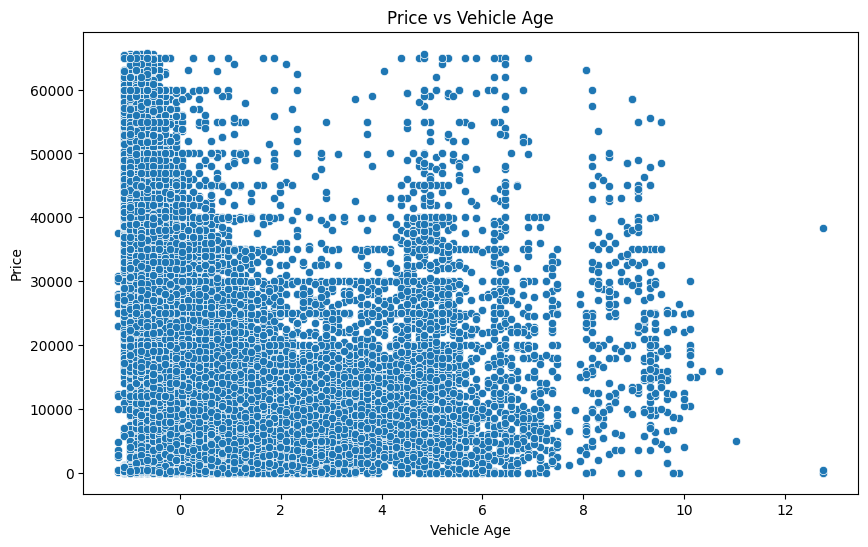

In [22]:
# Visualizing the relationship between vehicle age and price
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vehicle_age', y=df_train_y, data=df_train_x)
plt.xlabel('Vehicle Age')
plt.ylabel('Price')
plt.title('Price vs Vehicle Age')
plt.show()

The scatter plot illustrates a clear trend where the price of a vehicle decreases as its age increases. This is a typical pattern in vehicle valuation, reflecting depreciation over time. 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


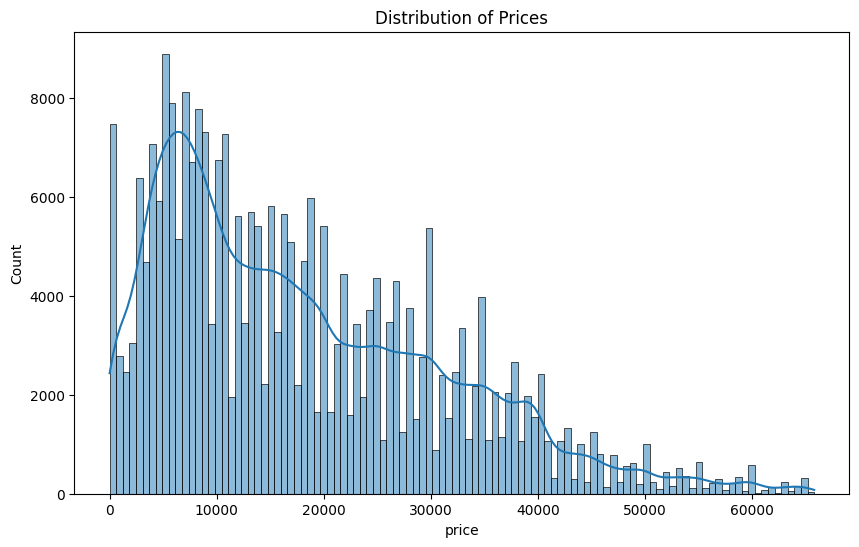

In [23]:
# Visualizing the distribution of prices to understand the spread
plt.figure(figsize=(10, 6))
sns.histplot(df_train_y, kde=True)
plt.title('Distribution of Prices')
plt.show()

The figure above shows that the distribution of vehicle prices is right-handed, with lower-priced vehicles appearing more frequently and decreasing in frequency as the price rises.

# **Training and Evaluation**

## Ensemble

### LGBM (boosting method)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current versio

best parms: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 1500, 'num_leaves': 192, 'subsample': 1}
best parms: 0.8052438845282879
Root Mean Squared Error: 5802.324391274346
Mean Absolute Error: 3165.6754517295685
R-squared: 0.8076870254856747


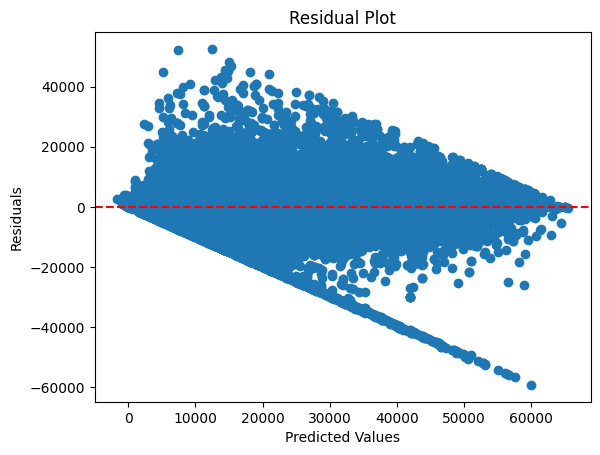

In [24]:
# training
numJobs=3
cv=3
paramgrid={
                "n_estimators": [1500],
                "num_leaves": [192],
                "subsample": [1],
                "colsample_bytree":[0.8],
                "learning_rate": [0.1],
            }

model = lgb.LGBMRegressor(n_estimators= 500,random_state=4487,objective='mae',learning_rate=0.05,importance_type= "gain",device="gpu",verbosity=-1)
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)

#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
print(f"best parms: {modelCV.best_score_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

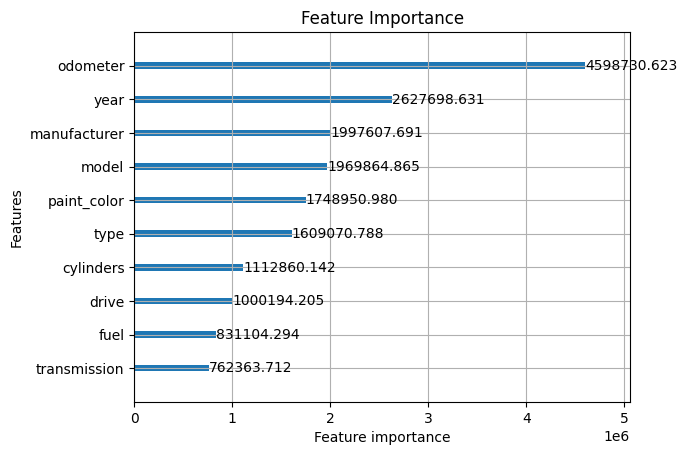

In [25]:
lgb.plot_importance(modelCV.best_estimator_, max_num_features=10)
plt.title('Feature Importance')
plt.show()

### CatBoost (boosting method)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
best parms: {'iterations': 1500, 'learning_rate': 0.1, 'random_state': 4487}
best parms: 0.77555651234305
Root Mean Squared Error: 6243.988915180326
Mean Absolute Error: 3622.4238083538817
R-squared: 0.777295587777752


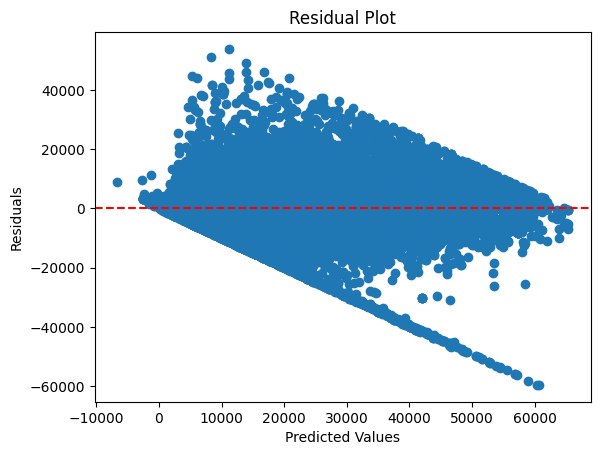

In [26]:
import catboost as cat
# training
numJobs=3
cv=3
paramgrid={
    'iterations':[1500],
    'random_state': [4487],
    "learning_rate": [0.1],
}
model = cat.CatBoostRegressor(objective='MAE',verbose=False)
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)


#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
print(f"best parms: {modelCV.best_score_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

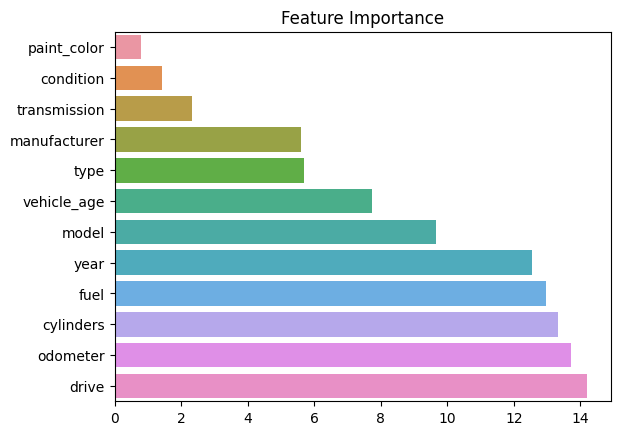

In [29]:
importances = modelCV.best_estimator_.get_feature_importance()
feature_importances = pd.Series(importances, index=df_train_x.columns).sort_values()
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title('Feature Importance')
plt.show()

### XGB (boosting method)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:22:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [07:22:31] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

best parms: {'eval_metric': 'mae', 'learning_rate': 0.41, 'n_estimators': 1500, 'random_state': 4487}
best parms: 0.860346867595307
Root Mean Squared Error: 4798.538199013595
Mean Absolute Error: 2769.428562904123
R-squared: 0.8684707065041064


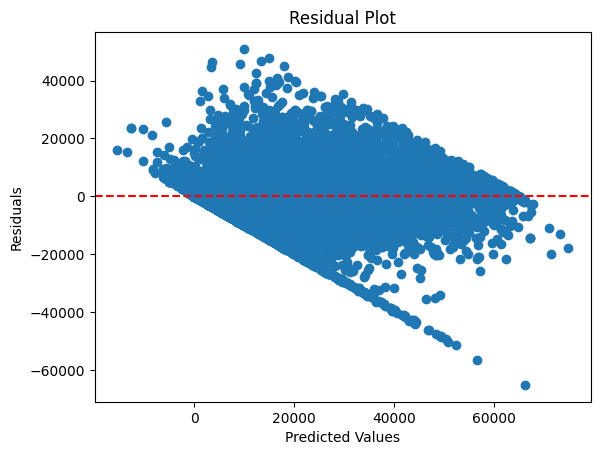

In [32]:
import xgboost as xgb
paramgrid={
    'n_estimators':[1500],
    'eval_metric': ['mae'],
    'random_state': [4487],
    'learning_rate': [0.1,0.41],
}
model=xgb.XGBRegressor(n_estimators = 500,tree_method = "hist", device = "cuda", eval_metric = 'mae')
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)
#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
print(f"best parms: {modelCV.best_score_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

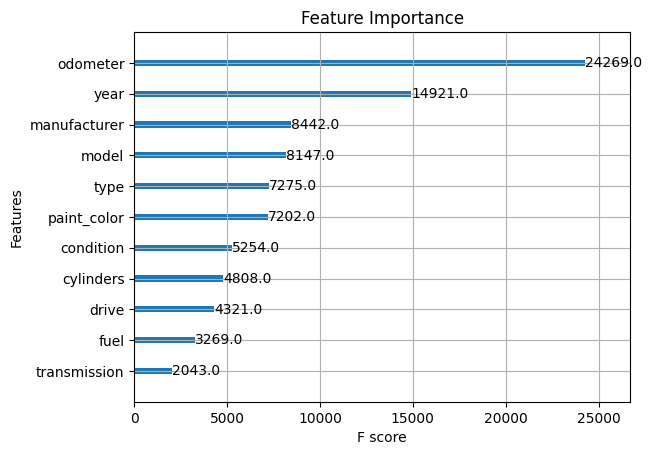

In [33]:
xgb.plot_importance(modelCV.best_estimator_)
plt.title('Feature Importance')
plt.show()

### Ensemble

Root Mean Squared Error: 5082.464626651316
Mean Absolute Error: 3049.027605482274
R-squared: 0.8524452128608346


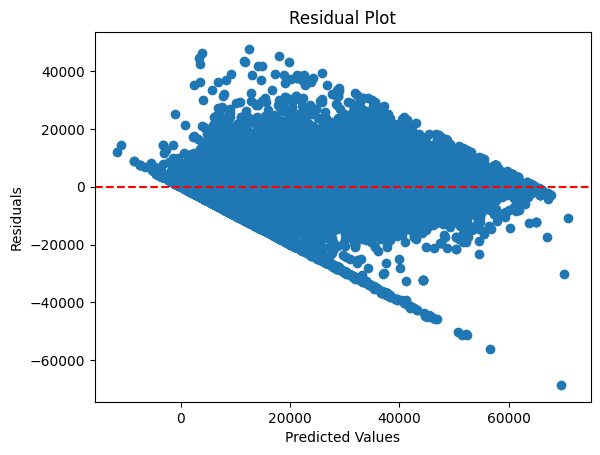

In [36]:
from sklearn.ensemble import StackingRegressor

lgbr = lgb.LGBMRegressor(n_estimators= 1500,random_state=4487,objective='mae',learning_rate=0.41,num_leaves=192,importance_type= "gain",device="gpu")
catr = cat.CatBoostRegressor(iterations=1500,random_state=4487,learning_rate=0.1,objective='MAE',verbose=False)
xgbr = xgb.XGBRegressor(n_estimators = 1500,random_state=4487,learning_rate=0.1,tree_method = "hist", device = "cuda", eval_metric = 'mae')
sr = StackingRegressor([('lgbr', lgbr), ('catr', catr), ('xgbr', xgbr)])
sr.fit(df_train_x, df_train_y)
y_pred = sr.predict(df_test_x)

# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


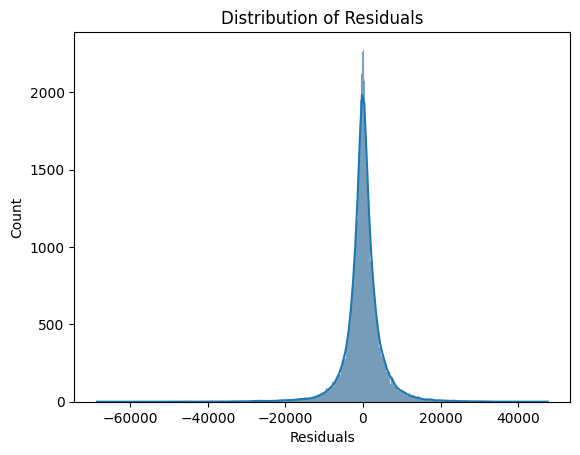

In [37]:
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Distribution of Residuals')
plt.show()

### Random Forest (bagging method)

Root Mean Squared Error: 5922.21348403467
Mean Absolute Error: 3733.3345277580956
R-squared: 0.7996576830102642


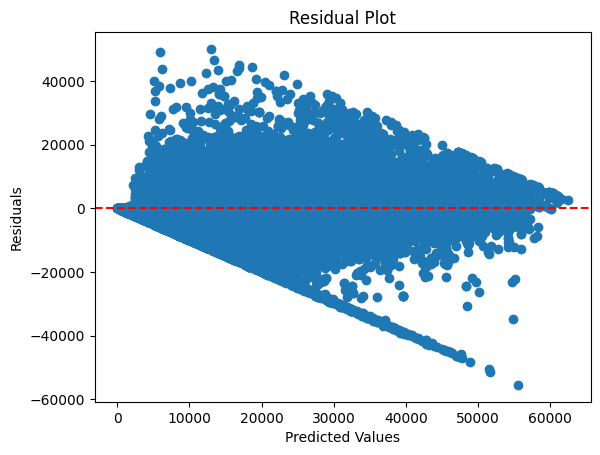

In [38]:
from sklearn.ensemble import RandomForestRegressor


regr = RandomForestRegressor(n_estimators=1500,max_depth=13,random_state=4487,n_jobs=-1)
regr.fit(df_train_x, df_train_y)
y_pred = regr.predict(df_test_x)


# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

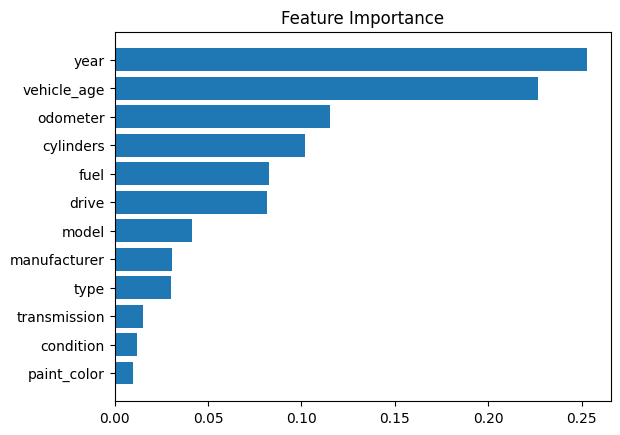

In [39]:
feature_importances = regr.feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(df_train_x.columns)[sorted_idx])
plt.title('Feature Importance')
plt.show()

### DecisionTreeRegressor 

Fitting 3 folds for each of 4 candidates, totalling 12 fits
best parms: {'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.0}
best parms: 0.8009328118169124
Root Mean Squared Error: 5664.676772198268
Mean Absolute Error: 2961.9500815684733
R-squared: 0.8167032171409627


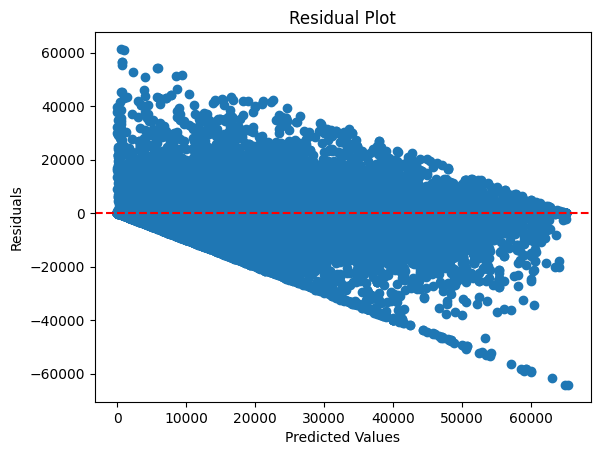

In [40]:
from sklearn.tree import DecisionTreeRegressor


paramgrid={
    'min_samples_leaf':np.arange(1,5),
    "min_weight_fraction_leaf": [0.0],
    'max_leaf_nodes':[None]
}

model=DecisionTreeRegressor()
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=cv)
modelCV.fit(df_train_x, df_train_y)
#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
print(f"best parms: {modelCV.best_score_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


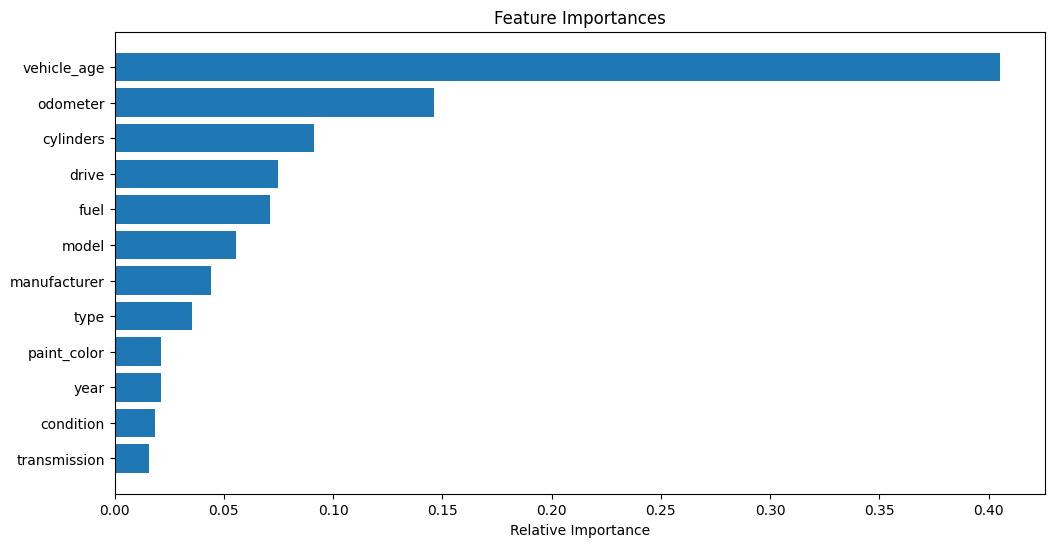

In [41]:
feature_importances = modelCV.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)

plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), feature_importances[indices], align='center')
plt.yticks(range(len(indices)), np.array(df_train_x.columns)[indices])
plt.xlabel('Relative Importance')
plt.show()

### Gradient Boost (type :boosting method)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
best parms: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'random_state': 4487, 'subsample': 1.0}
best parms: 0.8854153565987971
Root Mean Squared Error: 4322.804995146659
Mean Absolute Error: 2327.8148603230457
R-squared: 0.8932578702195804


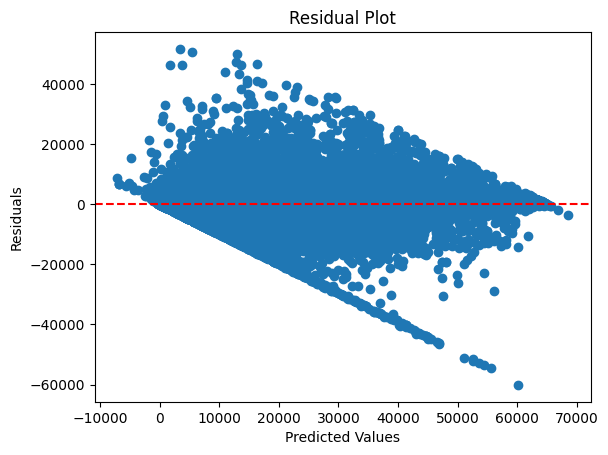

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

paramgrid={
    'n_estimators':[1000],
    'random_state': [4487],
    'learning_rate': [0.1],
    "max_depth": [10],
    "learning_rate": [0.1],
    "subsample": [1.0],
}

model=GradientBoostingRegressor()
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=3)
modelCV.fit(df_train_x, df_train_y)
#predict
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
print(f"best parms: {modelCV.best_score_}")
#evaluation
# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

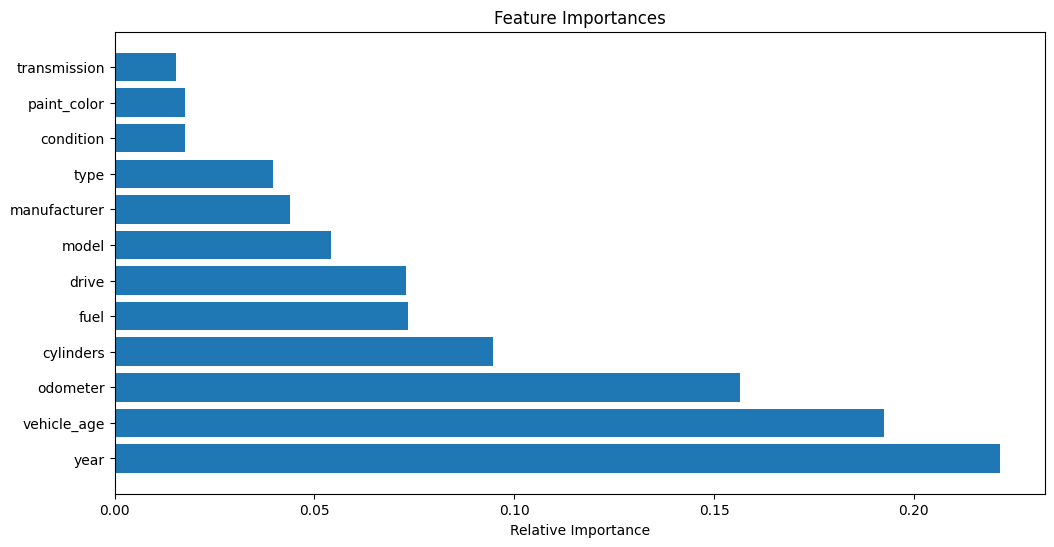

In [43]:
feature_importances = modelCV.best_estimator_.feature_importances_
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(12, 6))
plt.title('Feature Importances')
plt.barh(range(df_train_x.shape[1]), feature_importances[indices], align='center')
plt.yticks(range(df_train_x.shape[1]), df_train_x.columns[indices])
plt.xlabel('Relative Importance')
plt.show()

### Linear Regression

Fitting 3 folds for each of 1 candidates, totalling 3 fits
best parms: {}
best parms: 0.2829774337378936
Root Mean Squared Error: 11152.381129628619
Mean Absolute Error: 8573.00812073565
R-squared: 0.28953975644425634


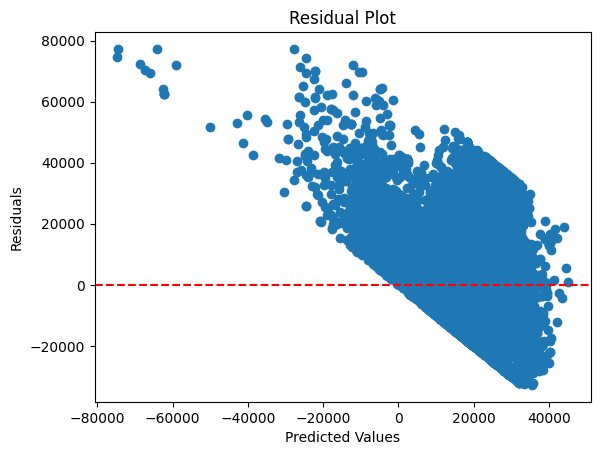

In [44]:
paramgrid={
    
}

model = LinearRegression()
modelCV= GridSearchCV(model,param_grid=paramgrid,n_jobs=numJobs,verbose=True,cv=3)
modelCV.fit(df_train_x, df_train_y)

#evaluation
y_pred = modelCV.predict(df_test_x)
print(f"best parms: {modelCV.best_params_}")
print(f"best parms: {modelCV.best_score_}")

# RMSE
rmse = np.sqrt(mean_squared_error(df_test_y, y_pred))
print(f"Root Mean Squared Error: {rmse}")

# MAE
mae = mean_absolute_error(df_test_y, y_pred)
print(f"Mean Absolute Error: {mae}")

# R2
r2 = r2_score(df_test_y, y_pred)
print(f"R-squared: {r2}")

#Residual Analysis: 
residuals = df_test_y - y_pred

plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()


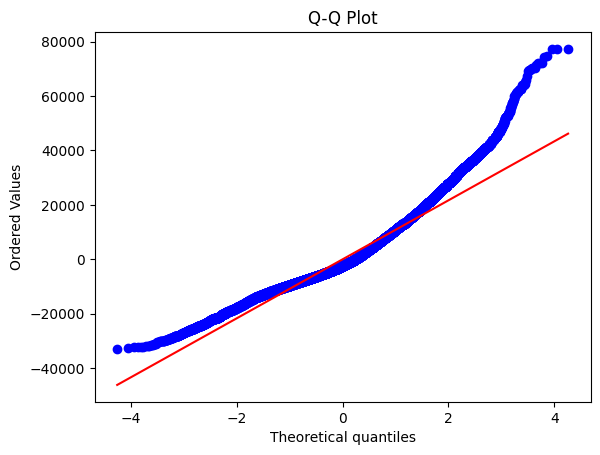

In [45]:
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot')
plt.show()

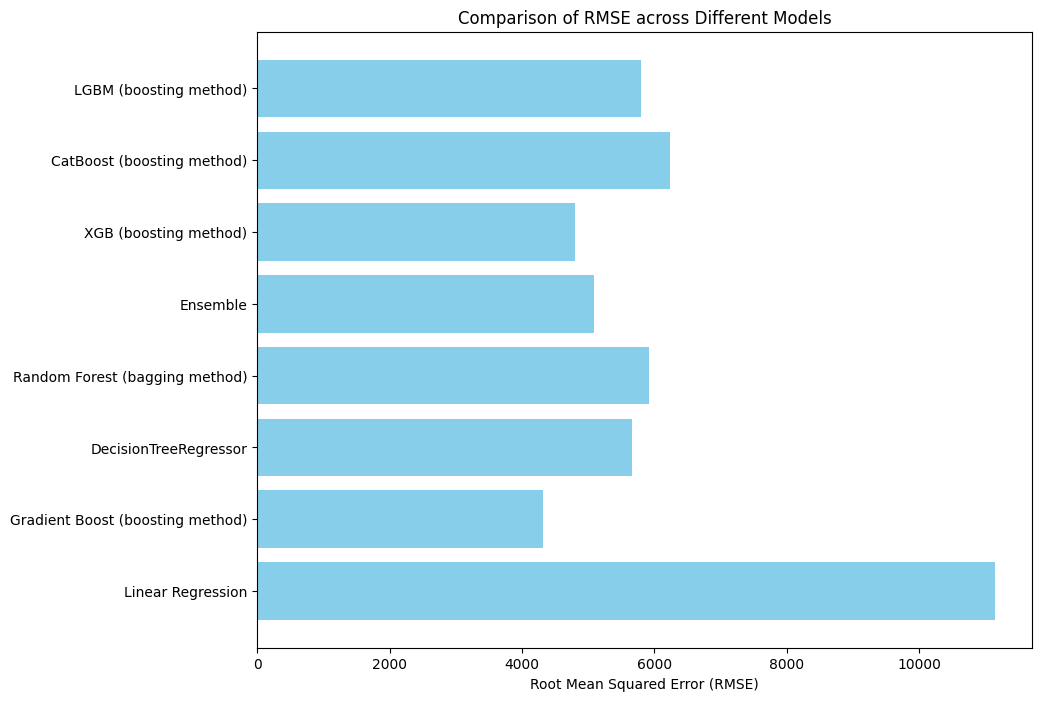

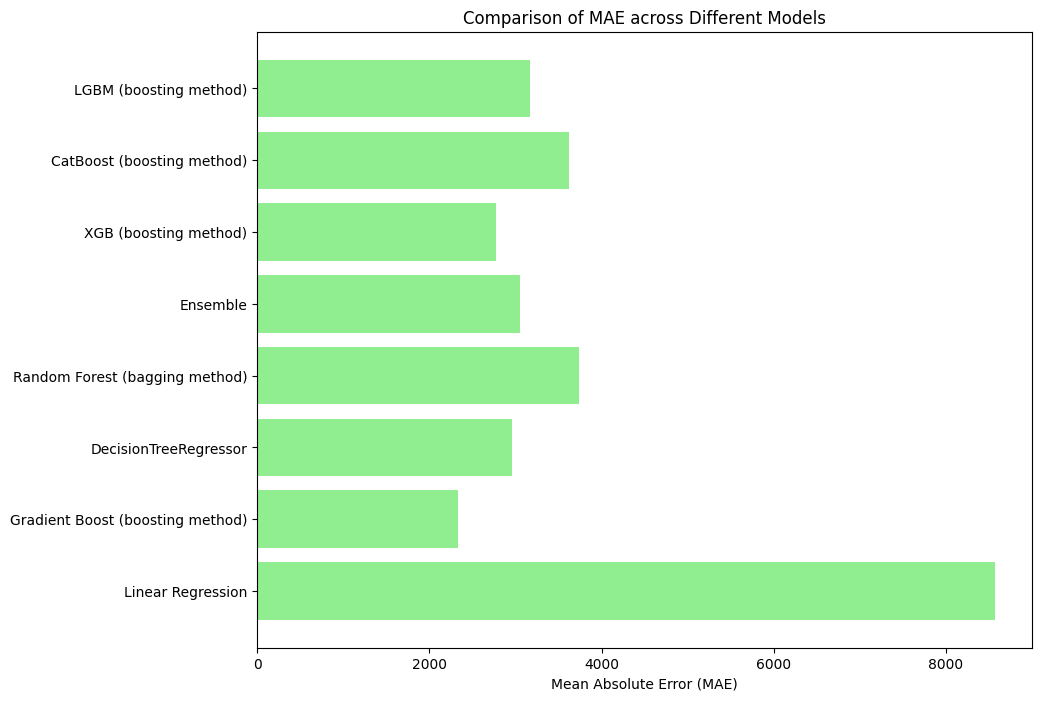

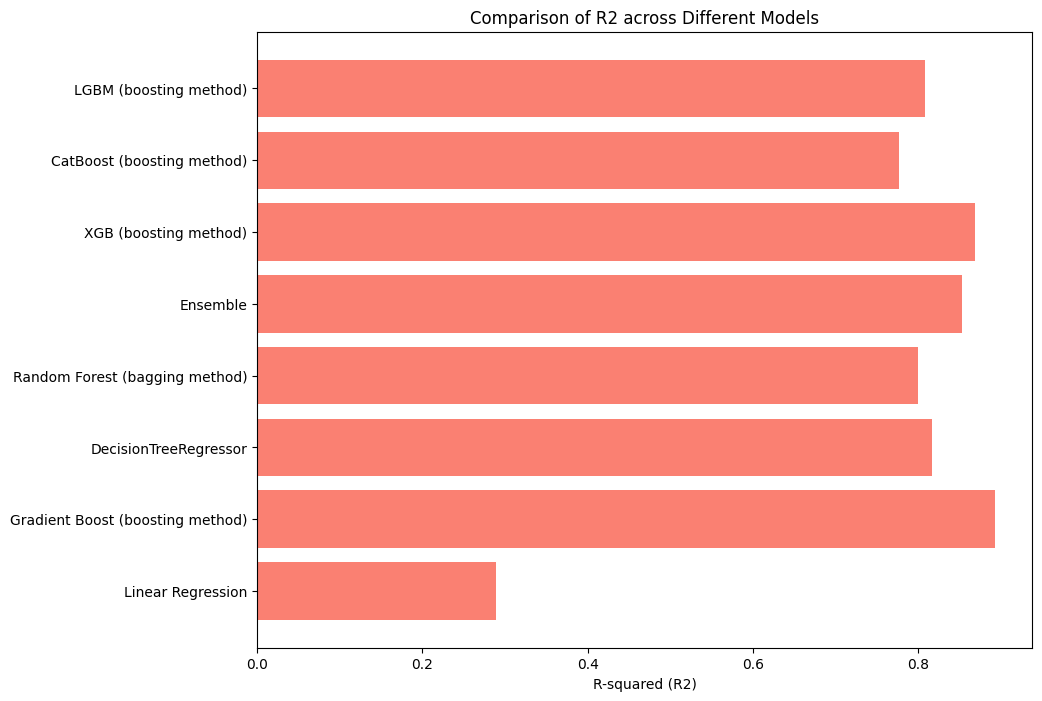

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

# Provided model performance data
model_data = {
    "Model": [
        "LGBM (boosting method)", "CatBoost (boosting method)", "XGB (boosting method)",
        "Ensemble", "Random Forest (bagging method)", "DecisionTreeRegressor",
        "Gradient Boost (boosting method)", "Linear Regression"
    ],
    "Best Parameters": [
        "{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'n_estimators': 1500, 'num_leaves': 192, 'subsample': 1}",
        "{'iterations': 1500, 'learning_rate': 0.1, 'random_state': 4487}",
        "{'eval_metric': 'mae', 'learning_rate': 0.41, 'n_estimators': 1500, 'random_state': 4487}",
        None,  # Ensemble models typically don't have a single best_params_
        None,  # Random Forest best parameters not provided
        "{'max_leaf_nodes': None, 'min_samples_leaf': 4, 'min_weight_fraction_leaf': 0.0}",
        "{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000, 'random_state': 4487, 'subsample': 1.0}",
        "{}"
    ],
    "Best Score": [
        0.8052438845282879, 0.77555651234305, 0.860346867595307,
        None,  # Best score not provided for Ensemble
        None,  # Best score not provided for Random Forest
        0.8009328118169124, 0.8854153565987971, 0.2829774337378936
    ],
    "RMSE": [
        5802.324391274346, 6243.988915180326, 4798.538199013595,
        5082.464626651316, 5922.21348403467, 5664.676772198268,
        4322.804995146659, 11152.381129628619
    ],
    "MAE": [
        3165.6754517295685, 3622.4238083538817, 2769.428562904123,
        3049.027605482274, 3733.3345277580956, 2961.9500815684733,
        2327.8148603230457, 8573.00812073565
    ],
    "R2": [
        0.8076870254856747, 0.777295587777752, 0.8684707065041064,
        0.8524452128608346, 0.7996576830102642, 0.8167032171409627,
        0.8932578702195804, 0.28953975644425634
    ]
}

# Create a DataFrame
df_model_comparison = pd.DataFrame(model_data)

# Display the DataFrame for a tabular comparison
df_model_comparison

# Plotting the comparison of RMSE for all models
plt.figure(figsize=(10, 8))
plt.barh(df_model_comparison['Model'], df_model_comparison['RMSE'], color='skyblue')
plt.xlabel('Root Mean Squared Error (RMSE)')
plt.title('Comparison of RMSE across Different Models')
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest RMSE on top
plt.show()

# Plotting the comparison of MAE for all models
plt.figure(figsize=(10, 8))
plt.barh(df_model_comparison['Model'], df_model_comparison['MAE'], color='lightgreen')
plt.xlabel('Mean Absolute Error (MAE)')
plt.title('Comparison of MAE across Different Models')
plt.gca().invert_yaxis()
plt.show()

# Plotting the comparison of R-squared for all models
plt.figure(figsize=(10, 8))
plt.barh(df_model_comparison['Model'], df_model_comparison['R2'], color='salmon')
plt.xlabel('R-squared (R2)')
plt.title('Comparison of R2 across Different Models')
plt.gca().invert_yaxis()
plt.show()


**Conclusion:**

1. **Ensemble Methods**: The high performance of ensemble methods, particularly Gradient Boosting, suggests that there are complex, non-linear relationships in the data, which ensemble methods can better capture.

2. **Boosting vs. Bagging**: Boosting methods (Gradient Boost, XGB, LGBM, CatBoost) outperform the bagging method (Random Forest) in this scenario. Boosting builds models sequentially to correct the previous model's errors, which might be particularly effective for the varying quality of data entries and the diverse range of features in used car listings. In contrast, bagging builds models in parallel and averages their predictions, which may be less effective when the model needs to correct for high bias.

4. **Linear Regression Limitations**: The poor performance of linear regression suggests that Car prices are not determined by a simple linear combination of features but are instead influenced by a more complicated set of factors and interactions.

5. **Decision Trees and Overfitting**: The Decision Tree model, while not performing as well as the ensemble methods, still captures a reasonable amount of variance indicated by the R-squared value. This points to the potential for overfitting with a single decision tree, which is mitigated in ensemble methods that aggregate many trees.